# بسم الله الرحمن الرحيم

# Import Libs

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from datetime import date

from scipy.stats import norm
from math import atanh
import string
from pandas.core.array_algos import replace
from scipy import stats
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout ,BatchNormalization ,Activation
from tensorflow.keras.callbacks import  ReduceLROnPlateau
import keras
import pickle
nltk.download('stopwords')

from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

#from google.colab import drive
#drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Functions

In [28]:
def States_Encoding(df,path):
  states=joblib.load(path)
  lon=list()
  lat=list()
  for i in df['State']:
    lon.append(states[i]['usa_state_longitude'])
    lat.append(states[i]['usa_state_latitude'])
  df['long']=lon
  df['lat']=lat
  df.drop(['State',"City"],axis=1,inplace=True)
  del lon
  del lat
  return df    

In [29]:
def Cols_To_DT(df,printout):
  cols=list(filter(lambda x:x.endswith("Date"),df.columns))
  for col in cols:
    df[col]= pd.to_datetime(df[col])
  if(printout==True):
    print(df.select_dtypes(include="datetime").columns,"Are Date Time")
  return df    


In [30]:
def dict_to_cols(df):
  MainCat=list()
  SubCat=list()
  for i in df['CategoryTree']:
    d=eval(i)
    MainCat.append(d['MainCategory'])
    SubCat.append(d['SubCategory'])
  df['MainCat']=MainCat
  df['SubCat']=SubCat
  df.drop("CategoryTree",axis=1,inplace=True)  
  return df

In [31]:
def preprocessed(df,object_cv,Scaler,cols,retY=False):
    #Date Time Prob
    df=Cols_To_DT(df,False)
    #Category Tree
    df=dict_to_cols(df)
    df['delivery days']=df['Ship Date']-df['Order Date']
    df['delivery days']=df['delivery days'].dt.days
    
    df.drop(["Ship Date","Row ID","Country"],axis=1,inplace=True)
    
    df['Quantity']=np.log2(df['Quantity']+1)
    df['Discount']=np.log2(df['Discount']+1)

    df['Product ID']=df['Product ID'].str.split('-',expand=True)[2].astype('int64')
    df['Customer ID']=df['Customer ID'].str.split('-',expand=True)[1].astype('int64')
    df['year']=df['Order ID'].str.split('-',expand=True)[1].astype('int64')
    df['month']=df['Order Date'].dt.month.astype('int64')
    df['Order IDs']=df['Order ID'].str.split('-',expand=True)[2].astype('int64')    
    df['Order IDs']=df['Order IDs'].astype('int64')
    df.drop(['Order ID',"Order Date"],axis=1,inplace=True)
    if(retY==True):
      X=df.drop('Profit',axis=1)
      Y=df.loc[:,'Profit']
    else:
      X=df  
    
    ###Remeber To write Scaler###
    scaled_cols=X.select_dtypes(exclude=["object"]).columns
    X[scaled_cols]=Scaler.transform(X[scaled_cols])

    X=States_Encoding(X,r"Saved Object/UStatesDict.pkl")
    num_feature=[0]
    
    for ghandy,i in enumerate(X.select_dtypes(include='object').columns):

        sentences = X[i].values
        cleaned_sentence = []
        for sentence in sentences:
            word = sentence.lower()  
            word = re.sub(r'^RT[\s]+', '', word)
            word = re.sub(r'#',"",word)
            word = word.split()
            word = [i for i in word if i not in set(stopwords.words('english'))]          
            word = " ".join(word)               ##joining our words back to sentences
            cleaned_sentence.append(word)       ##appending our preprocessed sentence into a new list
          

        BagofwordSs = object_cv[ghandy].transform(cleaned_sentence).toarray()
        num_feature.append(num_feature[-1]+BagofwordSs.shape[1])  
        if (ghandy==0):
          CumBagofwords = BagofwordSs
        else:
          CumBagofwords = np.concatenate([CumBagofwords,BagofwordSs],axis=1)

    X.drop(X.select_dtypes(include='object').columns,axis=1,inplace=True)
    result = pd.concat([X.reset_index(), pd.DataFrame(CumBagofwords)], axis=1)
    X=pd.DataFrame(result)   
    X.columns=X.columns.astype(str)
    #print(X.columns)
    new_X=X.loc[:,cols]
    if(retY==True):
        return new_X,Y
    else:
        return new_X

# Fetch Data

In [101]:
df=pd.read_csv(r"megastore-regression-dataset.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,CategoryTree,Product Name,Sales,Quantity,Discount,Profit
0,7492,US-2017-118598,11/16/2017,11/16/2017,Same Day,CM-12190,Charlotte Melton,Consumer,United States,Utica,New York,13501,East,TEC-PH-10002583,"{'MainCategory': 'Technology', 'SubCategory': ...",iOttie HLCRIO102 Car Mount,119.940,6,0.0,5.9970
1,6641,CA-2017-128328,8/5/2017,8/9/2017,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,Indianapolis,Indiana,46203,Central,OFF-BI-10001989,"{'MainCategory': 'Office Supplies', 'SubCatego...",Premium Transparent Presentation Covers by GBC,125.880,6,0.0,60.4224
2,9243,CA-2014-113271,7/9/2014,7/14/2014,Standard Class,DS-13030,Darrin Sayre,Home Office,United States,San Francisco,California,94122,West,OFF-BI-10002609,"{'MainCategory': 'Office Supplies', 'SubCatego...",Avery Hidden Tab Dividers for Binding Systems,14.304,6,0.2,4.6488
3,2469,CA-2017-128755,5/4/2017,5/8/2017,Standard Class,MK-18160,Mike Kennedy,Consumer,United States,Newport News,Virginia,23602,South,OFF-PA-10004983,"{'MainCategory': 'Office Supplies', 'SubCatego...",Xerox 23,32.400,5,0.0,15.5520
4,3136,CA-2017-164168,11/12/2017,11/18/2017,Standard Class,LS-16975,Lindsay Shagiari,Home Office,United States,Dallas,Texas,75081,Central,OFF-ST-10002583,"{'MainCategory': 'Office Supplies', 'SubCatego...",Fellowes Neat Ideas Storage Cubes,77.952,3,0.2,-15.5904


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7995 entries, 0 to 7994
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         7995 non-null   int64  
 1   Order ID       7995 non-null   object 
 2   Order Date     7995 non-null   object 
 3   Ship Date      7995 non-null   object 
 4   Ship Mode      7995 non-null   object 
 5   Customer ID    7995 non-null   object 
 6   Customer Name  7995 non-null   object 
 7   Segment        7995 non-null   object 
 8   Country        7995 non-null   object 
 9   City           7995 non-null   object 
 10  State          7995 non-null   object 
 11  Postal Code    7995 non-null   int64  
 12  Region         7995 non-null   object 
 13  Product ID     7995 non-null   object 
 14  CategoryTree   7995 non-null   object 
 15  Product Name   7995 non-null   object 
 16  Sales          7995 non-null   float64
 17  Quantity       7995 non-null   int64  
 18  Discount

In [103]:
nullreplacer=dict()
for col in df.columns:
    if df[col].dtype != 'object':
        nullreplacer[col]=df[col].mean()
    else:    
        nullreplacer[col]=df[col].mode()[0]

In [104]:
nullreplacer

{'Row ID': 5010.902564102564,
 'Order ID': 'CA-2017-100111',
 'Order Date': '11/10/2016',
 'Ship Date': '9/26/2017',
 'Ship Mode': 'Standard Class',
 'Customer ID': 'PP-18955',
 'Customer Name': 'Paul Prost',
 'Segment': 'Consumer',
 'Country': 'United States',
 'City': 'New York City',
 'State': 'California',
 'Postal Code': 55339.397123202005,
 'Region': 'West',
 'Product ID': 'OFF-PA-10001970',
 'CategoryTree': "{'MainCategory': 'Office Supplies', 'SubCategory': 'Binders'}",
 'Product Name': 'Staples',
 'Sales': 228.21197003126545,
 'Quantity': 3.7642276422764227,
 'Discount': 0.15588492808005827,
 'Profit': 30.130533758599}

## Train Test Split

In [33]:
from sklearn.model_selection import train_test_split
df,df_test=train_test_split(df,train_size=0.8,shuffle=True,random_state=2002)

In [34]:
df_test

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,CategoryTree,Product Name,Sales,Quantity,Discount,Profit
393,1634,CA-2016-106530,5/8/2016,5/8/2016,Same Day,CL-12565,Clay Ludtke,Consumer,United States,Cleveland,Ohio,44105,East,OFF-ST-10000649,"{'MainCategory': 'Office Supplies', 'SubCatego...",Hanging Personal Folder File,25.120,2,0.2,1.5700
5789,6440,CA-2014-166891,10/4/2014,10/6/2014,First Class,CC-12220,Chris Cortes,Consumer,United States,New York City,New York,10024,East,FUR-CH-10003298,"{'MainCategory': 'Furniture', 'SubCategory': '...",Office Star - Contemporary Task Swivel chair w...,589.410,5,0.1,-6.5490
2074,1989,CA-2015-127509,11/9/2015,11/13/2015,Standard Class,AS-10090,Adam Shillingsburg,Consumer,United States,Springfield,Missouri,65807,Central,FUR-TA-10002855,"{'MainCategory': 'Furniture', 'SubCategory': '...",Bevis Round Conference Table Top & Single Colu...,1024.380,7,0.0,215.1198
7276,9271,US-2017-102183,8/21/2017,8/28/2017,Standard Class,PK-19075,Pete Kriz,Consumer,United States,New York City,New York,10035,East,OFF-BI-10001359,"{'MainCategory': 'Office Supplies', 'SubCatego...",GBC DocuBind TL300 Electric Binding System,4305.552,6,0.2,1453.1238
1011,4967,CA-2015-122406,8/2/2015,8/5/2015,Second Class,BE-11455,Brad Eason,Home Office,United States,Providence,Rhode Island,2908,East,TEC-PH-10001527,"{'MainCategory': 'Technology', 'SubCategory': ...",Plantronics MX500i Earset,128.850,3,0.0,3.8655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,1917,CA-2017-124597,4/30/2017,5/5/2017,Standard Class,AS-10630,Ann Steele,Home Office,United States,Boynton Beach,Florida,33437,South,OFF-LA-10001569,"{'MainCategory': 'Office Supplies', 'SubCatego...",Avery 499,11.952,3,0.2,3.8844
3808,4849,CA-2014-164469,6/25/2014,6/27/2014,Second Class,GK-14620,Grace Kelly,Corporate,United States,Salem,Oregon,97301,West,OFF-AR-10000475,"{'MainCategory': 'Office Supplies', 'SubCatego...",Hunt BOSTON Vista Battery-Operated Pencil Shar...,9.328,1,0.2,0.8162
7435,548,CA-2017-162929,11/19/2017,11/22/2017,First Class,AS-10135,Adrian Shami,Home Office,United States,New York City,New York,10035,East,OFF-PA-10002986,"{'MainCategory': 'Office Supplies', 'SubCatego...",Xerox 1898,13.360,2,0.0,6.4128
5167,9893,US-2016-115441,7/25/2016,7/28/2016,Second Class,SH-19975,Sally Hughsby,Corporate,United States,Milwaukee,Wisconsin,53209,Central,TEC-PH-10002262,"{'MainCategory': 'Technology', 'SubCategory': ...",LG Electronics Tone+ HBS-730 Bluetooth Headset,297.550,5,0.0,83.3140


In [35]:
df.shape,df_test.shape

((6396, 20), (1599, 20))

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 6800 to 5713
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         6396 non-null   int64  
 1   Order ID       6396 non-null   object 
 2   Order Date     6396 non-null   object 
 3   Ship Date      6396 non-null   object 
 4   Ship Mode      6396 non-null   object 
 5   Customer ID    6396 non-null   object 
 6   Customer Name  6396 non-null   object 
 7   Segment        6396 non-null   object 
 8   Country        6396 non-null   object 
 9   City           6396 non-null   object 
 10  State          6396 non-null   object 
 11  Postal Code    6396 non-null   int64  
 12  Region         6396 non-null   object 
 13  Product ID     6396 non-null   object 
 14  CategoryTree   6396 non-null   object 
 15  Product Name   6396 non-null   object 
 16  Sales          6396 non-null   float64
 17  Quantity       6396 non-null   int64  
 18  Disco

In [37]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,CategoryTree,Product Name,Sales,Quantity,Discount,Profit
6800,6060,CA-2014-138072,12/30/2014,1/3/2015,Standard Class,GA-14725,Guy Armstrong,Consumer,United States,Philadelphia,Pennsylvania,19120,East,TEC-AC-10004859,"{'MainCategory': 'Technology', 'SubCategory': ...","Maxell Pro 80 Minute CD-R, 10/Pack",27.968,2,0.2,6.9920
6590,2656,CA-2017-112515,9/17/2017,9/21/2017,Second Class,AS-10225,Alan Schoenberger,Corporate,United States,Provo,Utah,84604,West,OFF-BI-10004233,"{'MainCategory': 'Office Supplies', 'SubCatego...","GBC Pre-Punched Binding Paper, Plastic, White,...",25.584,2,0.2,8.9544
1277,8454,CA-2016-125087,4/18/2016,4/23/2016,Standard Class,TH-21115,Thea Hudgings,Corporate,United States,Houston,Texas,77070,Central,OFF-ST-10001780,"{'MainCategory': 'Office Supplies', 'SubCatego...",Tennsco 16-Compartment Lockers with Coat Rack,1554.936,3,0.2,77.7468
2012,7986,CA-2016-151498,4/21/2016,4/24/2016,First Class,DN-13690,Duane Noonan,Consumer,United States,Seattle,Washington,98115,West,OFF-BI-10004967,"{'MainCategory': 'Office Supplies', 'SubCatego...",Round Ring Binders,8.320,5,0.2,2.8080
2234,7687,CA-2016-169838,11/25/2016,11/29/2016,Standard Class,BB-11545,Brenda Bowman,Corporate,United States,Jackson,Michigan,49201,Central,FUR-TA-10001095,"{'MainCategory': 'Furniture', 'SubCategory': '...",Chromcraft Round Conference Tables,1568.610,9,0.0,329.4081


In [38]:
df['Order Date']=pd.to_datetime(df['Order Date'])

### Here we Read The data and we found


1.   We have No Nulls
2.   Category Tree column is not written well
3.   We have to deal with (Order Date and Ship Date)






##Converting Datatypes

In [39]:
#Date DataType Preparation
df=Cols_To_DT(df,True)
#Fixing Dictionary Problem of CategoryTree
df=dict_to_cols(df)

Index(['Order Date', 'Ship Date'], dtype='object') Are Date Time


In [40]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Product Name,Sales,Quantity,Discount,Profit,MainCat,SubCat
6800,6060,CA-2014-138072,2014-12-30,2015-01-03,Standard Class,GA-14725,Guy Armstrong,Consumer,United States,Philadelphia,...,19120,East,TEC-AC-10004859,"Maxell Pro 80 Minute CD-R, 10/Pack",27.968,2,0.2,6.9920,Technology,Accessories
6590,2656,CA-2017-112515,2017-09-17,2017-09-21,Second Class,AS-10225,Alan Schoenberger,Corporate,United States,Provo,...,84604,West,OFF-BI-10004233,"GBC Pre-Punched Binding Paper, Plastic, White,...",25.584,2,0.2,8.9544,Office Supplies,Binders
1277,8454,CA-2016-125087,2016-04-18,2016-04-23,Standard Class,TH-21115,Thea Hudgings,Corporate,United States,Houston,...,77070,Central,OFF-ST-10001780,Tennsco 16-Compartment Lockers with Coat Rack,1554.936,3,0.2,77.7468,Office Supplies,Storage
2012,7986,CA-2016-151498,2016-04-21,2016-04-24,First Class,DN-13690,Duane Noonan,Consumer,United States,Seattle,...,98115,West,OFF-BI-10004967,Round Ring Binders,8.320,5,0.2,2.8080,Office Supplies,Binders
2234,7687,CA-2016-169838,2016-11-25,2016-11-29,Standard Class,BB-11545,Brenda Bowman,Corporate,United States,Jackson,...,49201,Central,FUR-TA-10001095,Chromcraft Round Conference Tables,1568.610,9,0.0,329.4081,Furniture,Tables


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 6800 to 5713
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         6396 non-null   int64         
 1   Order ID       6396 non-null   object        
 2   Order Date     6396 non-null   datetime64[ns]
 3   Ship Date      6396 non-null   datetime64[ns]
 4   Ship Mode      6396 non-null   object        
 5   Customer ID    6396 non-null   object        
 6   Customer Name  6396 non-null   object        
 7   Segment        6396 non-null   object        
 8   Country        6396 non-null   object        
 9   City           6396 non-null   object        
 10  State          6396 non-null   object        
 11  Postal Code    6396 non-null   int64         
 12  Region         6396 non-null   object        
 13  Product ID     6396 non-null   object        
 14  Product Name   6396 non-null   object        
 15  Sales          639

In [42]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,6396.000000,6396.000000,6396.000000,6396.000000,6396.000000,6396.000000
mean,4996.729831,55188.242183,229.328373,3.780175,0.156865,30.172305
std,2884.333195,31929.953761,591.893515,2.217668,0.206598,222.676858
min,2.000000,1453.000000,0.444000,1.000000,0.000000,-3839.990400
25%,2507.500000,23456.500000,16.735000,2.000000,0.000000,1.790100
50%,4994.500000,55901.000000,53.770000,3.000000,0.200000,8.529000
75%,7500.250000,90004.000000,208.745000,5.000000,0.200000,29.145600
max,9994.000000,99301.000000,13999.960000,14.000000,0.800000,6719.980800


In [43]:
df['delivery days']=df['Ship Date']-df['Order Date']
df['delivery days']=df['delivery days'].dt.days
df['delivery days']=df['delivery days'].astype('float64')
df['year']=df['Order ID'].str.split('-',expand=True)[1].astype('int64') 
df['month']=df['Order Date'].dt.month.astype('int64')
df.drop(["Ship Date"],axis=1,inplace=True)

## Here We have dealt with Datatypes and extracted some other features


1.   We expanded the dictionary in category tree into 2 columns by using (dict_to_cols)
2.   We Turned any feature that ends with "Date" to Datetime datatype 
3.   We created Delivery Days feature




# Analysis

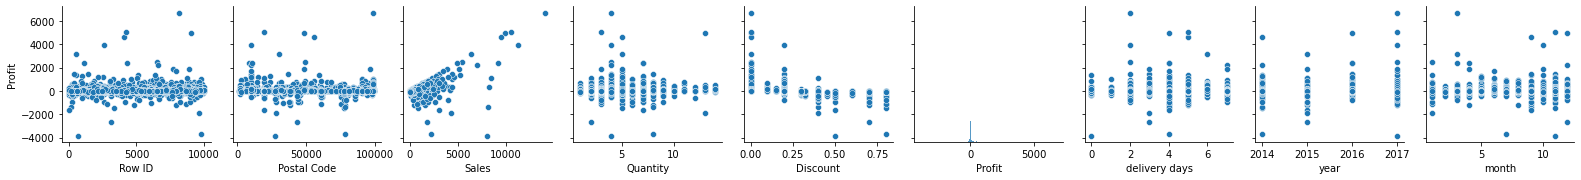

In [44]:
sns.pairplot(df,kind='scatter',y_vars='Profit')

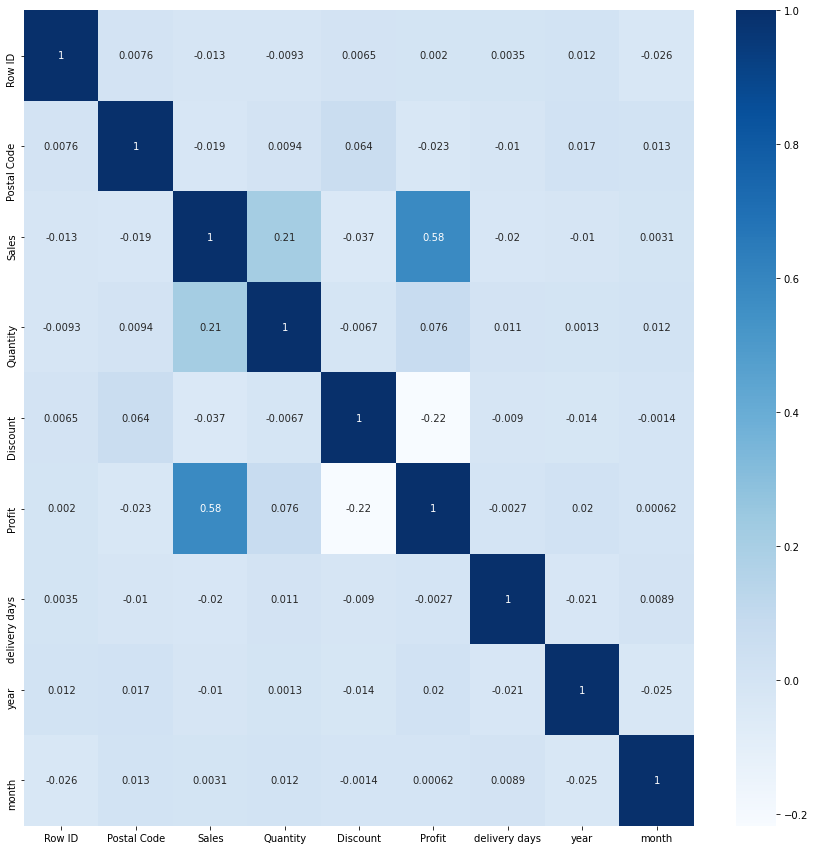

In [45]:
plt.figure(figsize=(15,15))
sns.heatmap(data=df.corr(),cmap='Blues',annot=True)
plt.show()

In [46]:
for col in df.columns:
  if df[col].nunique()==1:
    print(col+" column has one unique value")

Country column has one unique value


 

*   Here we will drop Row ID column because it is too low
*   We will drop Country columns because it has ine unique value

In [47]:
df.drop("Row ID",axis=1,inplace=True)
df.drop("Country",axis=1,inplace=True)

In [48]:
import plotly.graph_objects as go
import plotly.express as px
Taa=df
cols=df.select_dtypes(exclude =['object','datetime']).columns
fig = go.Figure(data=
    go.Parcoords(line = dict(color = Taa['Profit'], colorscale =px.colors.sequential.Blues),
        dimensions = [dict(label=col, values=Taa[col]) for col in cols]))

fig.update_layout(title="Profit")
fig.update_layout(autosize=False,width=2100,height=800)
fig.show()

From the Above Graph We noticed that

*   Products with Zero Discount Gives high profit because it is high quality products the have high rate of selling and they do not lose from its original price
*   Some products with low sales get sold with large quantities because the may beg cheap



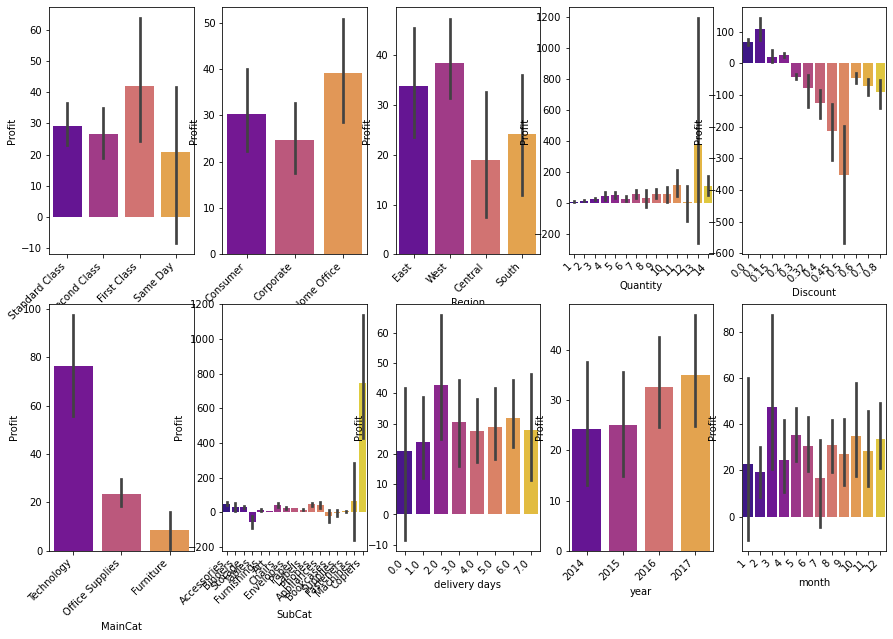

In [49]:
w=int(len(df.select_dtypes(exclude=['datetime','object']).columns)/2)+1
fig, ax = plt.subplots(2,w,figsize=(15,10))
z=1
for i in df[df.columns[df.nunique()<20]]:
    plt.subplot(2,w,z)
    df[['Profit',i]].groupby([i],as_index=False).mean().sort_values(by='Profit',ascending=False)
    sns.barplot(x =i, y ='Profit', data = df,palette ='plasma')
    plt.xticks(rotation=45, ha='right')
    z=z+1

From The Above Graph we Noticed


1.   The Mean profit goes high along the years
2.   Technology are the highest profitable products
3.   Copiers Have the highest profit in SubCat which makes sense why Technology Profit is Significally High
4.   January does not have much profit according to no of products sold due to hogh competition between lots of products that causes high profit in some and low in others




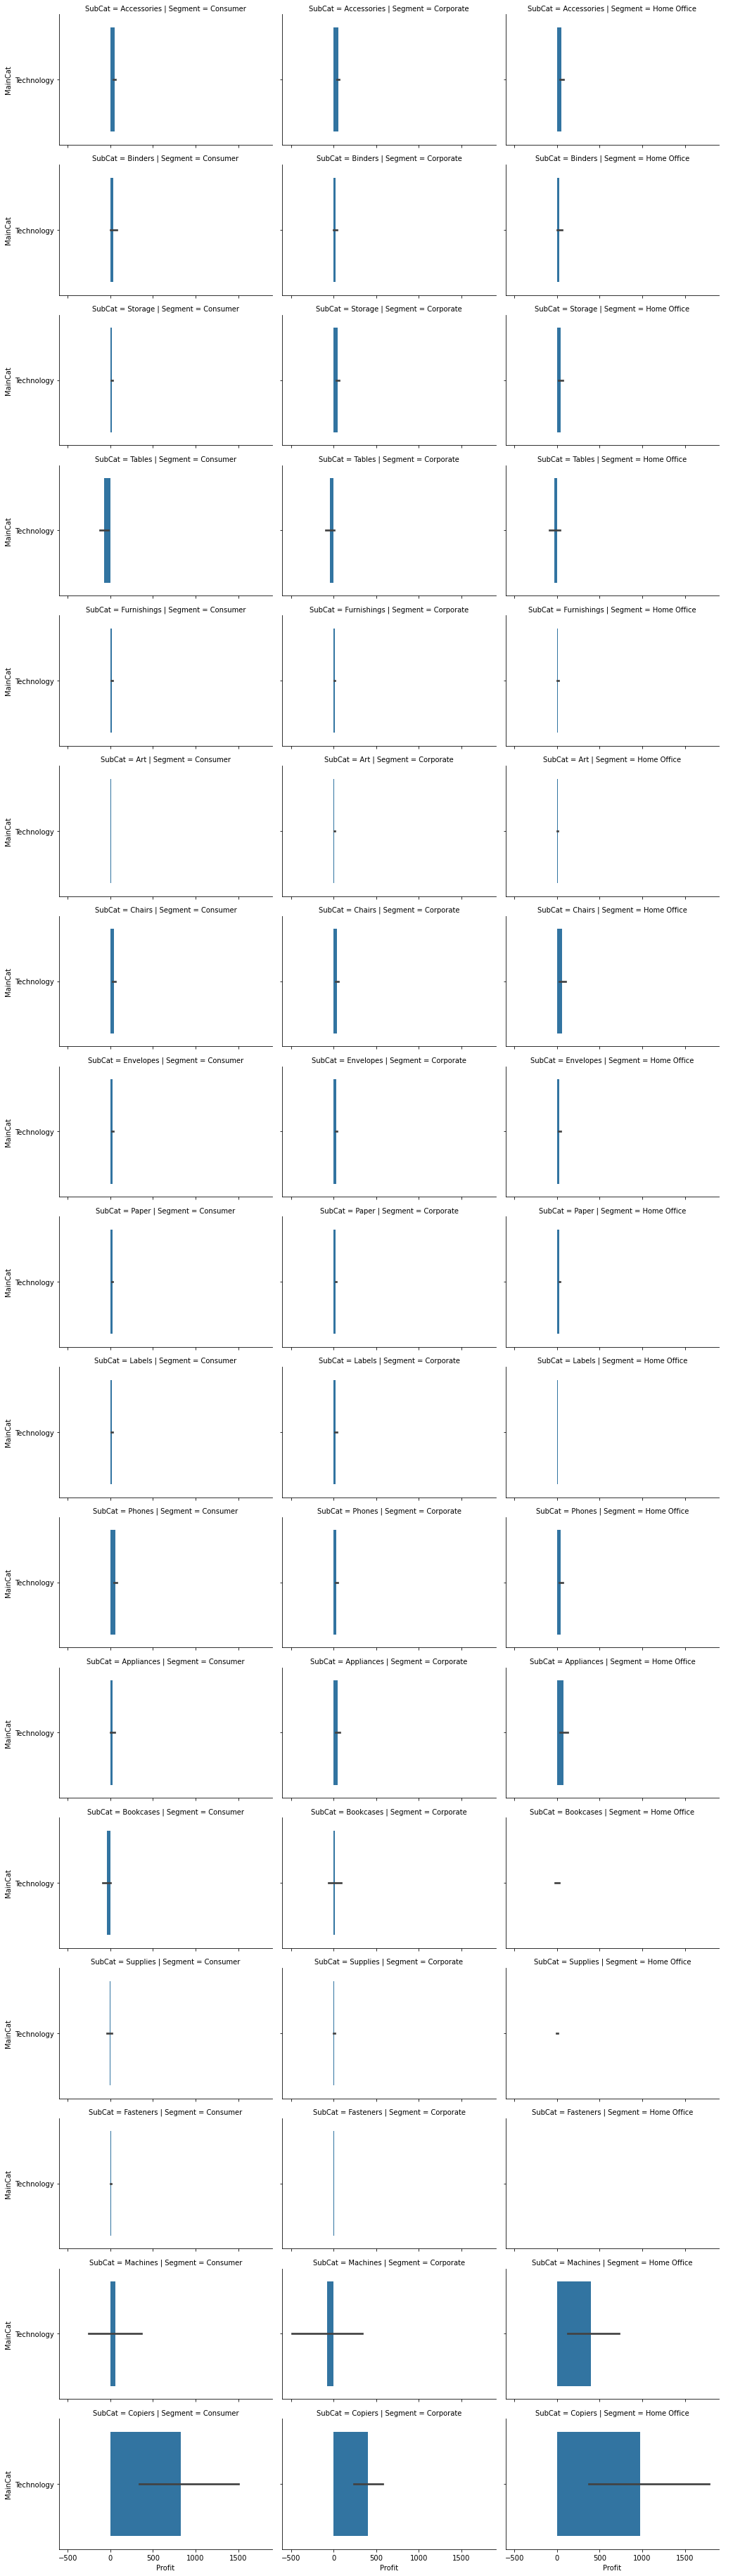

In [50]:
grid = sns.FacetGrid(df, row='SubCat', col='Segment', aspect=1.6)
grid.map(sns.barplot ,'Profit', 'MainCat').add_legend()

In [51]:
fig=px.sunburst(df,path=['Segment',"MainCat",'SubCat'])
fig.update_traces(textinfo="label+percent parent")
fig.show()

In The Above chart it seems strange that the least percentage of the Segments are home officies while they are the most profitable segments.

In [53]:
fig=px.sunburst(df,path=['Segment',"Discount",'Quantity'])
fig.update_traces(textinfo="label+percent parent")
fig.show()

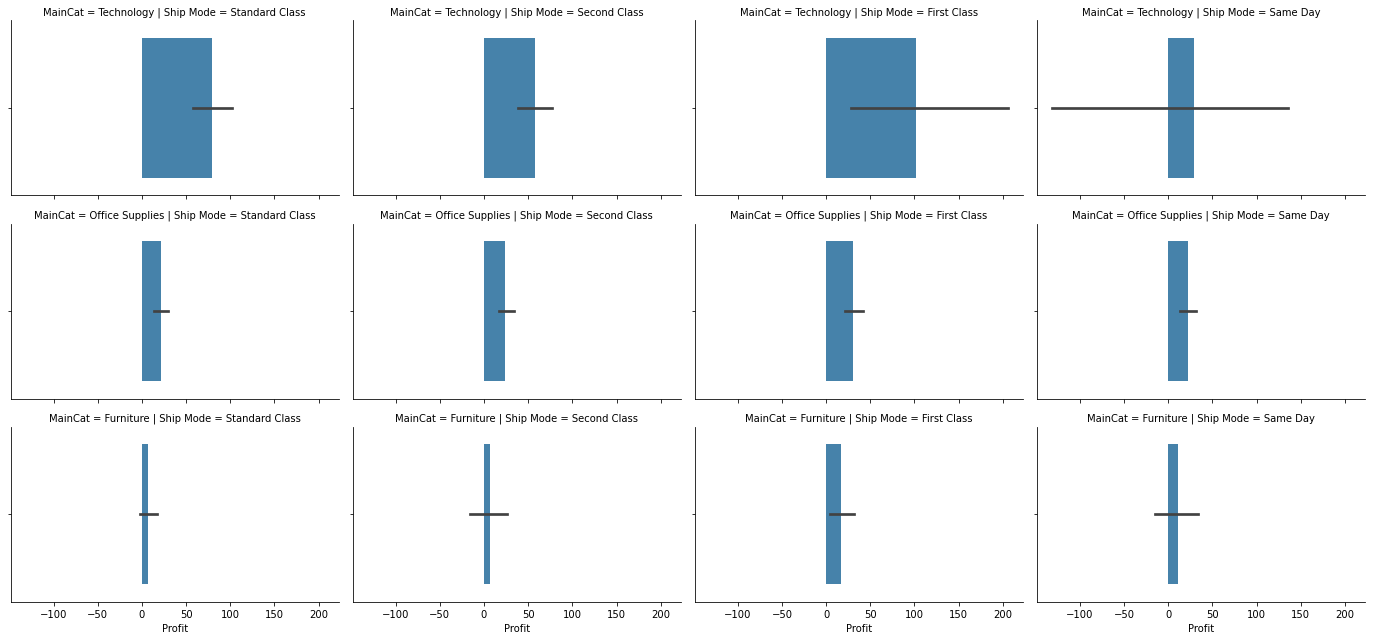

In [54]:
grid = sns.FacetGrid(df, row='MainCat', col='Ship Mode', aspect=1.6)
grid.map(sns.barplot ,'Profit',alpha=.9).add_legend()

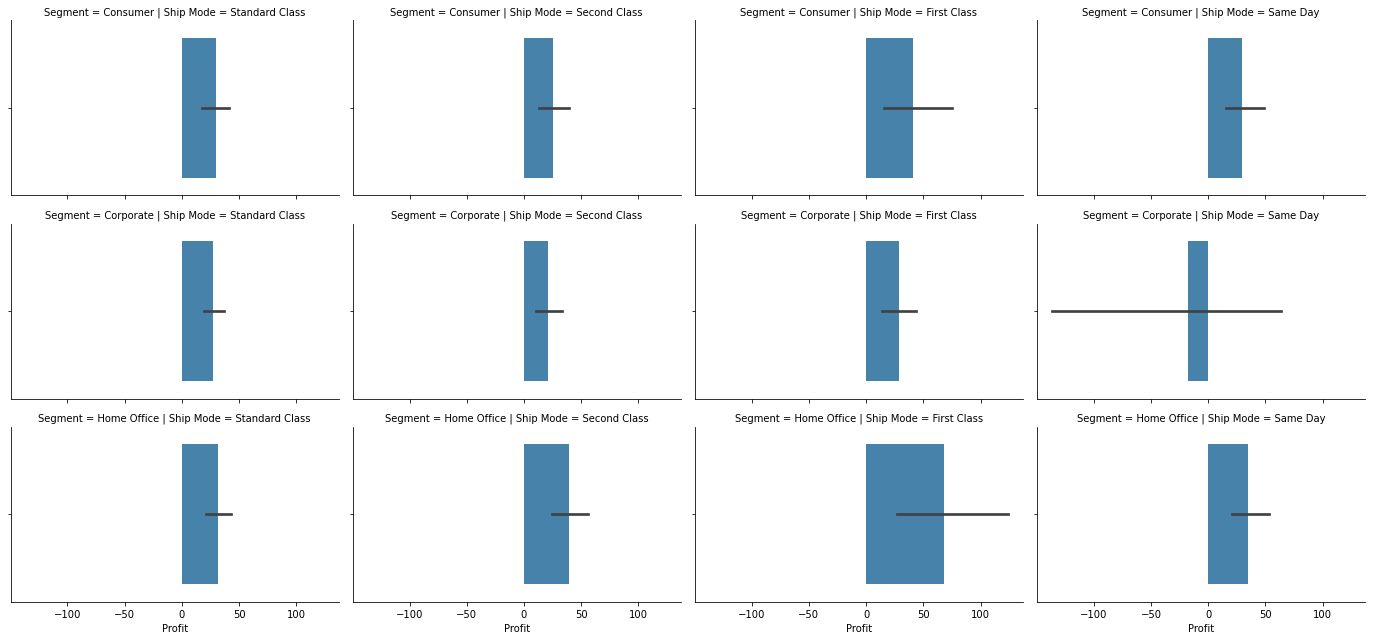

In [55]:
grid = sns.FacetGrid(df, row='Segment', col='Ship Mode', aspect=1.6)
grid.map(sns.barplot ,'Profit',alpha=.9).add_legend()

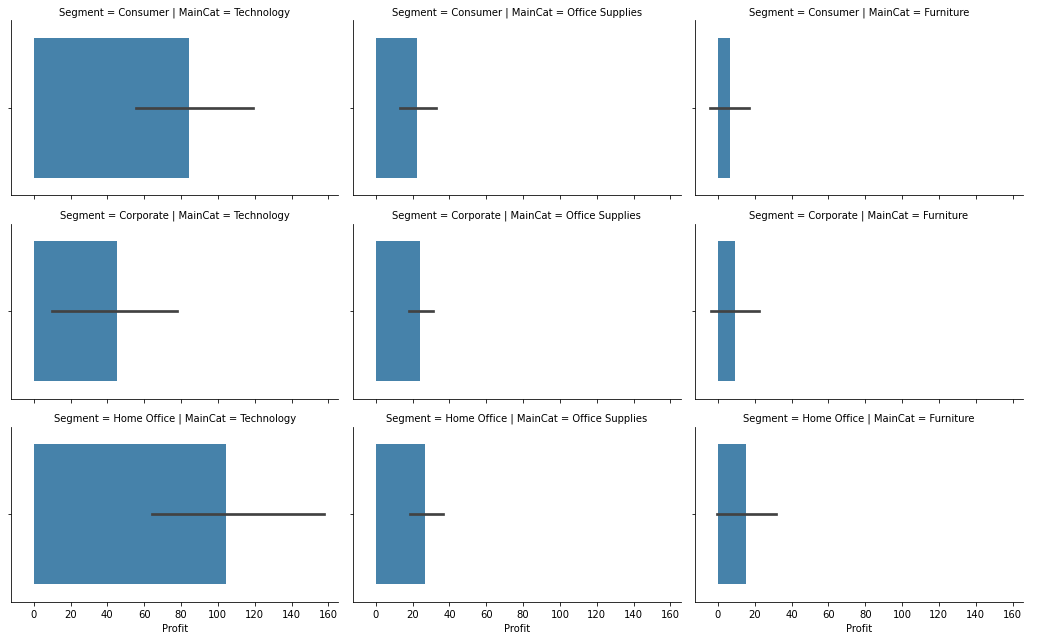

In [56]:
grid = sns.FacetGrid(df, row='Segment', col='MainCat', aspect=1.6)
grid.map(sns.barplot ,'Profit',alpha=.9).add_legend()

Text(0.5, 1.0, 'Max Customer Name buy')

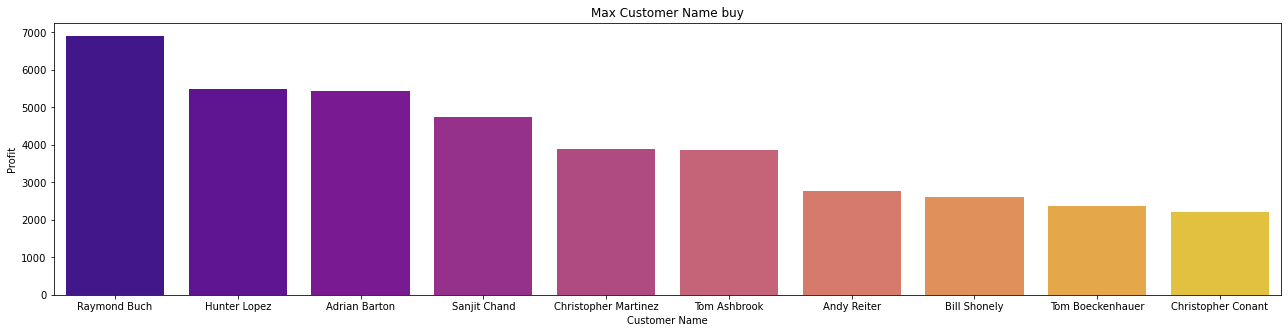

In [57]:
G7=df[['Customer Name','Profit']].groupby(['Customer Name'],as_index=False).sum().sort_values(by='Profit',ascending=False)

plt.figure(figsize=(22, 5))
sns.barplot(x ='Customer Name', y ='Profit', data = G7[:10],  palette ='plasma')
plt.title('Max Customer Name buy')

Text(0.5, 1.0, 'Most Frequent State Purchase')

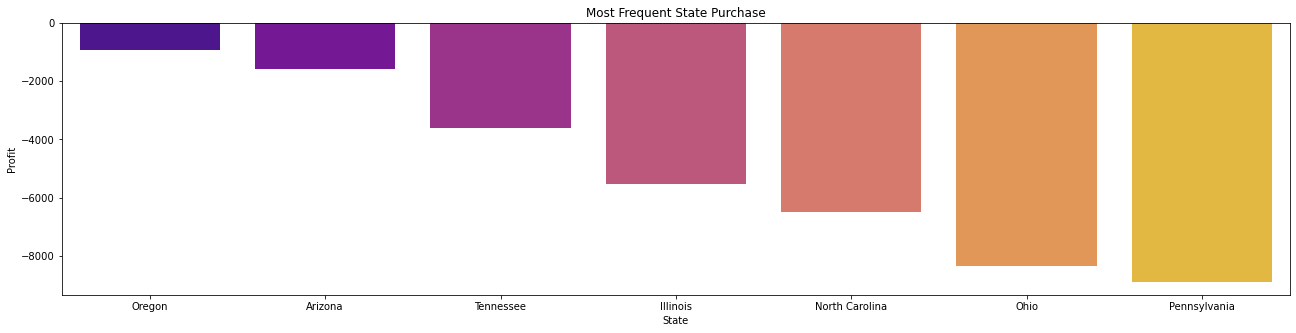

In [58]:
G7=df[['State','Profit']].groupby(['State'],as_index=False).sum().sort_values(by='Profit',ascending=False)

plt.figure(figsize=(22, 5))
sns.barplot(x ='State', y ='Profit', data = G7[-8:-1],  
            palette ='plasma')
plt.title('Most Frequent State Purchase')

Text(0.5, 1.0, 'Max Customer Name buy')

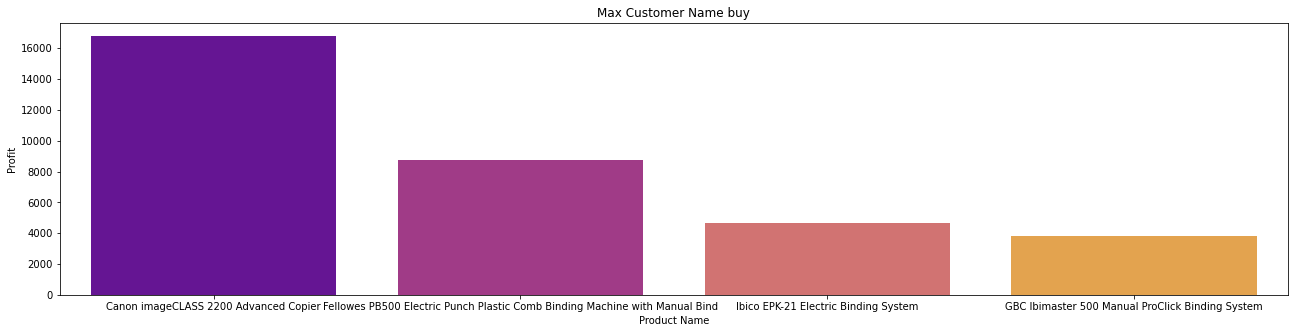

In [59]:
G7=df[['Product Name','Profit']].groupby(['Product Name'],as_index=False).sum().sort_values(by='Profit',ascending=False)

plt.figure(figsize=(22, 5))
sns.barplot(x ='Product Name', y ='Profit', data = G7[:4],palette ='plasma')
plt.title('Max Customer Name buy')

Text(0.5, 1.0, 'Max Customer Name buy')

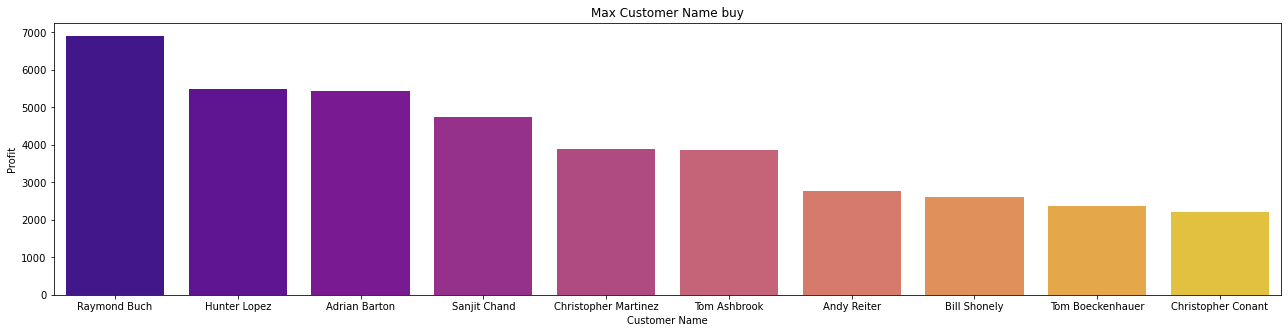

In [60]:
G7=df[['Customer Name','Profit']].groupby(['Customer Name'],as_index=False).sum().sort_values(by='Profit',ascending=False)

plt.figure(figsize=(22, 5))
sns.barplot(x ='Customer Name', y ='Profit', data = G7[:10],  
            palette ='plasma')
plt.title('Max Customer Name buy')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 6800 to 5713
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       6396 non-null   object        
 1   Order Date     6396 non-null   datetime64[ns]
 2   Ship Mode      6396 non-null   object        
 3   Customer ID    6396 non-null   object        
 4   Customer Name  6396 non-null   object        
 5   Segment        6396 non-null   object        
 6   City           6396 non-null   object        
 7   State          6396 non-null   object        
 8   Postal Code    6396 non-null   int64         
 9   Region         6396 non-null   object        
 10  Product ID     6396 non-null   object        
 11  Product Name   6396 non-null   object        
 12  Sales          6396 non-null   float64       
 13  Quantity       6396 non-null   int64         
 14  Discount       6396 non-null   float64       
 15  Profit         639

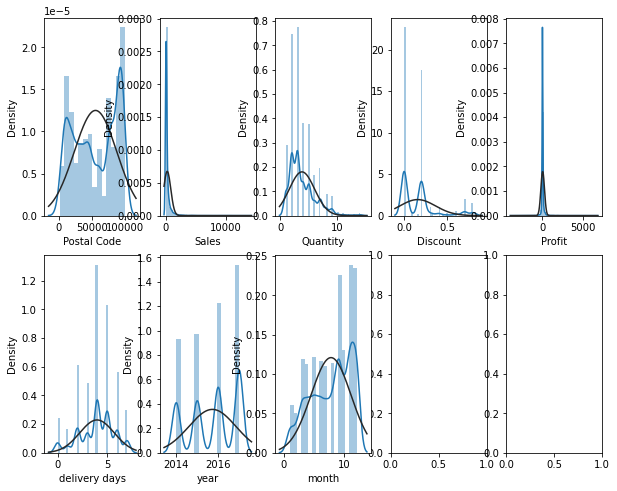

In [62]:
w=int(len(df.select_dtypes(exclude=['datetime','object']).columns)/2)+1

fig, ax = plt.subplots(2,w,figsize=(10,8))
z=1
for z,i in enumerate( df.select_dtypes(exclude=['object','datetime']).columns):
  plt.subplot(2,w,z+1)
  sns.distplot(df[i], fit=norm);
        

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 6800 to 5713
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       6396 non-null   object        
 1   Order Date     6396 non-null   datetime64[ns]
 2   Ship Mode      6396 non-null   object        
 3   Customer ID    6396 non-null   object        
 4   Customer Name  6396 non-null   object        
 5   Segment        6396 non-null   object        
 6   City           6396 non-null   object        
 7   State          6396 non-null   object        
 8   Postal Code    6396 non-null   int64         
 9   Region         6396 non-null   object        
 10  Product ID     6396 non-null   object        
 11  Product Name   6396 non-null   object        
 12  Sales          6396 non-null   float64       
 13  Quantity       6396 non-null   int64         
 14  Discount       6396 non-null   float64       
 15  Profit         639

In [64]:
df['Quantity']=np.log2(df['Quantity']+1)
df['Discount']=np.log2(df['Discount']+1)

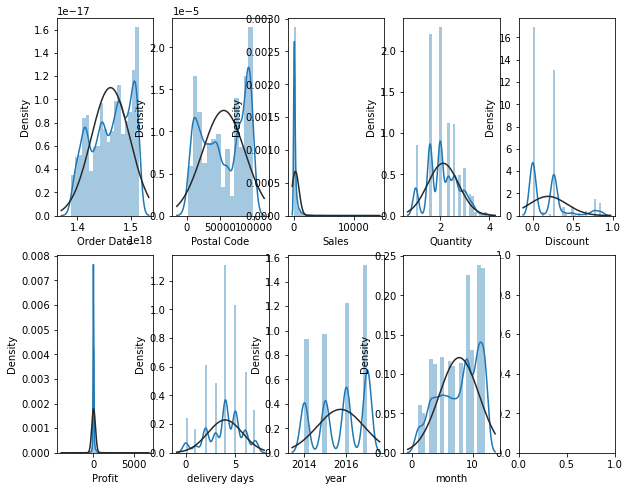

In [65]:
w=int(len(df.select_dtypes(exclude=['datetime','object']).columns)/2)+1

fig, ax = plt.subplots(2,w,figsize=(10,8))
z=1
for i in df.columns:
    if(df[i].dtypes!='object'):
        plt.subplot(2,w,z)
        sns.distplot(df[i], fit=norm);
        z=z+1

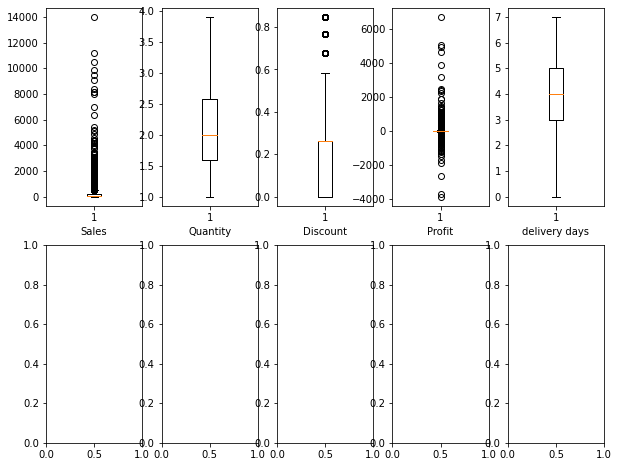

In [66]:
w=int(len(df.select_dtypes(exclude=['datetime','object']).columns)/2)+1

fig, ax = plt.subplots(2,w,figsize=(10,8))
z=1
for i in df.select_dtypes(include=['float','int']).columns:
  plt.subplot(2,w,z)
  plt.boxplot(df[i]);
  plt.xlabel(i)
  z=z+1

# Dealing With Categorical Features

In [67]:
df['Product ID']=df['Product ID'].str.split('-',expand=True)[2].astype('int64')
df['Customer ID']=df['Customer ID'].str.split('-',expand=True)[1].astype('int64')
df['Order IDs']=df['Order ID'].str.split('-',expand=True)[2].astype('int64')    
df.drop(['Order ID',"Order Date"],axis=1,inplace=True)

In This Part We tried to extract features 

1.   We extracted the numerical value in Prodict ID despite it has a pattern
2.   We extracted the numerical value in Customer ID despite it has a pattern
3.   We extracted the numerical value in Order ID despite it has a pattern



In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 6800 to 5713
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ship Mode      6396 non-null   object 
 1   Customer ID    6396 non-null   int64  
 2   Customer Name  6396 non-null   object 
 3   Segment        6396 non-null   object 
 4   City           6396 non-null   object 
 5   State          6396 non-null   object 
 6   Postal Code    6396 non-null   int64  
 7   Region         6396 non-null   object 
 8   Product ID     6396 non-null   int64  
 9   Product Name   6396 non-null   object 
 10  Sales          6396 non-null   float64
 11  Quantity       6396 non-null   float64
 12  Discount       6396 non-null   float64
 13  Profit         6396 non-null   float64
 14  MainCat        6396 non-null   object 
 15  SubCat         6396 non-null   object 
 16  delivery days  6396 non-null   float64
 17  year           6396 non-null   int64  
 18  month

In [69]:
scale=MinMaxScaler(feature_range=(-1,1))
scale.fit(df.select_dtypes(exclude=["datetime","object"]).drop("Profit",axis=1))
scaled_cols=df.select_dtypes(exclude=["datetime","object"]).drop("Profit",axis=1).columns
df[scaled_cols]=scale.transform(df[scaled_cols])

Here We Scaled The features Between -1 and 1

In [70]:
df=States_Encoding(df,r"Saved Object/UStatesDict.pkl")

In [71]:
df

,Ship Mode,Customer ID,Customer Name,Segment,Postal Code,Region,Product ID,Product Name,Sales,Quantity,Discount,Profit,MainCat,SubCat,delivery days,year,month,Order IDs,long,lat
6800,Standard Class,-0.209068,Guy Armstrong,Consumer,-0.638889,East,0.943944,"Maxell Pro 80 Minute CD-R, 10/Pack",-0.996068,-0.597534,-0.379634,6.9920,Technology,Accessories,0.142857,-1.000000,1.000000,0.087618,-77.194525,41.203322
6590,Second Class,-0.964736,Alan Schoenberger,Corporate,0.699595,West,0.693293,"GBC Pre-Punched Binding Paper, Plastic, White,...",-0.996408,-0.597534,-0.379634,8.9544,Office Supplies,Binders,0.142857,1.000000,0.454545,-0.642729,-111.093731,39.320980
1277,Standard Class,0.863980,Thea Hudgings,Corporate,0.545601,Central,-0.288889,Tennsco 16-Compartment Lockers with Coat Rack,-0.777922,-0.311980,-0.379634,77.7468,Office Supplies,Storage,0.428571,0.333333,-0.454545,-0.283457,-99.901813,31.968599
2012,First Class,-0.382872,Duane Noonan,Consumer,0.975758,West,0.987187,Round Ring Binders,-0.998875,0.090487,-0.379634,2.8080,Office Supplies,Binders,-0.142857,0.333333,-0.454545,0.471294,-120.740139,47.751074
2234,Standard Class,-0.743073,Brenda Bowman,Corporate,-0.024037,Central,-0.563163,Chromcraft Round Conference Tables,-0.775969,0.597534,-1.000000,329.4081,Furniture,Tables,0.142857,0.333333,0.818182,0.995399,-85.602364,44.314844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5804,Standard Class,-0.916877,Andrew Roberts,Consumer,-0.638603,East,0.236436,Motorola L804,-0.992179,-0.597534,0.144879,-10.1178,Technology,Phones,0.142857,-1.000000,-0.272727,-0.835567,-77.194525,41.203322
5449,First Class,0.410579,Nathan Cano,Consumer,0.546112,Central,0.550350,Avery Hi-Liter GlideStik Fluorescent Highlight...,-0.998201,0.090487,-0.379634,3.9120,Office Supplies,Art,-0.428571,1.000000,0.818182,-0.107221,-99.901813,31.968599
904,Standard Class,-0.168766,Henry Goldwyn,Corporate,0.624009,West,-0.788188,Southworth Parchment Paper & Envelopes,-0.997821,-0.311980,-0.379634,5.1012,Office Supplies,Paper,0.142857,-0.333333,1.000000,0.603321,-105.782067,39.550051
4498,First Class,0.924433,Tony Chapman,Home Office,-0.128158,East,-0.572773,GBC ProClick Punch Binding System,-0.989095,-0.090487,0.805513,-53.7432,Office Supplies,Binders,-0.142857,1.000000,0.090909,0.592519,-82.907123,40.417287


In This Part We used a dictionary that of scrapped data that contains Longitude and Latitude of each state so we can find patterns that is related to order Shipping distance and price and polputation of purchases.

In [72]:
def ordinal_enccoder(df):
    num_feature=[0]
    c_v=[]
    for ghandy,i in enumerate(df.select_dtypes(include='object').columns):

        sentences = df[i].values
        cleaned_sentence = []
        for sentence in sentences:
            word = sentence.lower()  
            word = re.sub(r'^RT[\s]+', '', word)
            word = re.sub(r'#',"",word)
            word = word.split()
            word = [i for i in word if i not in set(stopwords.words('english'))]          
            word = " ".join(word)               ##joining our words back to sentences
            cleaned_sentence.append(word)       ##appending our preprocessed sentence into a new list
            
      
        ## printing our new list
        ## printing our new list
        
        cv = CountVectorizer(max_features = 7)  ##give it a max features as 3
        
        BagofwordSs = cv.fit_transform(cleaned_sentence).toarray()
        
        c_v.append(cv)
        
        num_feature.append(num_feature[-1]+BagofwordSs.shape[1])  
        if (ghandy==0):
          CumBagofwords = BagofwordSs
        else:
          CumBagofwords = np.concatenate([CumBagofwords,BagofwordSs],axis=1)
    
    df.drop(df.select_dtypes(include='object').columns,axis=1,inplace=True)
    result = pd.concat([df.reset_index(), pd.DataFrame(CumBagofwords)], axis=1)
    df=pd.DataFrame(result)   
    return result ,num_feature,c_v


In [73]:
df,num_feature,object_cv=ordinal_enccoder(df)

In [74]:
num_feature

[0, 5, 12, 16, 20, 27, 31, 38]

In [75]:
df.head()

,index,Customer ID,Postal Code,Product ID,Sales,Quantity,Discount,Profit,delivery days,year,...,28,29,30,31,32,33,34,35,36,37
0,6800,-0.209068,-0.638889,0.943944,-0.996068,-0.597534,-0.379634,6.9920,0.142857,-1.000000,...,0,0,1,1,0,0,0,0,0,0
1,6590,-0.964736,0.699595,0.693293,-0.996408,-0.597534,-0.379634,8.9544,0.142857,1.000000,...,1,1,0,0,0,1,0,0,0,0
2,1277,0.863980,0.545601,-0.288889,-0.777922,-0.311980,-0.379634,77.7468,0.428571,0.333333,...,1,1,0,0,0,0,0,0,0,1
3,2012,-0.382872,0.975758,0.987187,-0.998875,0.090487,-0.379634,2.8080,-0.142857,0.333333,...,1,1,0,0,0,1,0,0,0,0
4,2234,-0.743073,-0.024037,-0.563163,-0.775969,0.597534,-1.000000,329.4081,0.142857,0.333333,...,0,0,0,0,0,0,0,0,0,0


In [76]:
df.columns=df.columns.astype(str)
# Applying SelectKBest class to extract top 20 best features
fs = SelectKBest(score_func=f_regression,k=30)
# Applying feature selection
fit = fs.fit(df.drop('Profit',axis=1),df['Profit'])
features_score = pd.DataFrame(fit.scores_)
features = pd.DataFrame(df.columns)
feature_score = pd.concat([features,features_score],axis=1)
# Assigning column names
feature_score.columns = ["Input_Features","F_Score"]
print(feature_score.nlargest(30,columns="F_Score"))


   Input_Features      F_Score
4           Sales  3242.742407
6        Discount   322.332020
43             29    62.561840
12           long    57.688181
5        Quantity    34.613560
40             26    16.122498
41             27     8.289048
42             28     8.289048
45             31     5.462819
29             15     5.086392
34             20     4.814603
33             19     4.291252
32             18     4.002624
44             30     3.882636
38             24     3.785210
49             35     3.760428
47             33     3.540283
2     Postal Code     3.444909
15              1     3.139158
8   delivery days     2.532458
27             13     2.191763
28             14     2.191763
26             12     1.714945
3      Product ID     1.597851
24             10     0.889705
31             17     0.881325
30             16     0.703005
48             34     0.646358
13            lat     0.626037
14              0     0.626037


In [77]:
cols=feature_score.nlargest(30,columns="F_Score")['Input_Features'][:30]
cols=np.array(cols)
df= pd.DataFrame(df,columns=df.columns);


In [78]:
X=df.loc[:,cols]
y=df['Profit']
X.head()

,Sales,Discount,29,long,Quantity,26,27,28,31,15,...,13,14,12,Product ID,10,17,16,34,lat,0
0,-0.996068,-0.379634,0,-77.194525,-0.597534,0,0,0,1,0,...,0,0,1,0.943944,0,1,0,0,41.203322,1
1,-0.996408,-0.379634,1,-111.093731,-0.597534,0,0,1,0,0,...,1,0,0,0.693293,0,0,0,0,39.320980,1
2,-0.777922,-0.379634,1,-99.901813,-0.311980,0,0,1,0,0,...,1,0,0,-0.288889,0,0,1,0,31.968599,1
3,-0.998875,-0.379634,1,-120.740139,0.090487,0,0,1,0,0,...,0,0,1,0.987187,0,0,0,0,47.751074,1
4,-0.775969,-1.000000,0,-85.602364,0.597534,0,1,0,0,0,...,1,0,0,-0.563163,0,0,1,0,44.314844,1


In [79]:
columns=list()
for col in X.columns:
    if(col.isnumeric()):
        for idx in range(len(num_feature)-1):
            if(num_feature[idx] <= int(col) and int(col) <num_feature[idx+1]):
                X=X.drop(col,axis=1)
                for ranga in range(num_feature[idx],num_feature[idx+1]):
                    if(str(ranga) not in columns):
                        columns.append(str(ranga))

In That Part We :


1.   used Count vectorizer to encode text in categorical data so simmilar feature have small eculidian distance
1.   We use F_score in feature selection
1.   We returned the other diminisions of diminsions of features we dropped



In [80]:
X=pd.concat([X,df[columns]],axis=1)

In [81]:
cols_list=X.columns

In [82]:
X

,Sales,Discount,long,Quantity,Postal Code,delivery days,Product ID,lat,27,28,...,2,3,4,5,6,7,8,9,10,11
0,-0.996068,-0.379634,-77.194525,-0.597534,-0.638889,0.142857,0.943944,41.203322,0,0,...,0,0,1,0,0,0,0,0,0,0
1,-0.996408,-0.379634,-111.093731,-0.597534,0.699595,0.142857,0.693293,39.320980,0,1,...,0,1,0,0,0,0,0,0,0,0
2,-0.777922,-0.379634,-99.901813,-0.311980,0.545601,0.428571,-0.288889,31.968599,0,1,...,0,0,1,0,0,0,0,0,0,0
3,-0.998875,-0.379634,-120.740139,0.090487,0.975758,-0.142857,0.987187,47.751074,0,1,...,1,0,0,0,0,0,0,0,0,0
4,-0.775969,-1.000000,-85.602364,0.597534,-0.024037,0.142857,-0.563163,44.314844,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6391,-0.992179,0.144879,-77.194525,-0.597534,-0.638603,0.142857,0.236436,41.203322,0,0,...,0,0,1,0,0,0,0,0,0,0
6392,-0.998201,-0.379634,-99.901813,0.090487,0.546112,-0.428571,0.550350,31.968599,0,1,...,1,0,0,0,0,0,0,0,0,0
6393,-0.997821,-0.379634,-105.782067,-0.311980,0.624009,0.142857,-0.788188,39.550051,0,1,...,0,0,1,0,0,0,0,0,0,0
6394,-0.989095,0.805513,-82.907123,-0.090487,-0.128158,-0.142857,-0.572773,40.417287,0,1,...,1,0,0,0,0,0,0,0,0,0


In [83]:
num_feature

[0, 5, 12, 16, 20, 27, 31, 38]

In [84]:
X_train=X
y_train=y

In [85]:
X_train

,Sales,Discount,long,Quantity,Postal Code,delivery days,Product ID,lat,27,28,...,2,3,4,5,6,7,8,9,10,11
0,-0.996068,-0.379634,-77.194525,-0.597534,-0.638889,0.142857,0.943944,41.203322,0,0,...,0,0,1,0,0,0,0,0,0,0
1,-0.996408,-0.379634,-111.093731,-0.597534,0.699595,0.142857,0.693293,39.320980,0,1,...,0,1,0,0,0,0,0,0,0,0
2,-0.777922,-0.379634,-99.901813,-0.311980,0.545601,0.428571,-0.288889,31.968599,0,1,...,0,0,1,0,0,0,0,0,0,0
3,-0.998875,-0.379634,-120.740139,0.090487,0.975758,-0.142857,0.987187,47.751074,0,1,...,1,0,0,0,0,0,0,0,0,0
4,-0.775969,-1.000000,-85.602364,0.597534,-0.024037,0.142857,-0.563163,44.314844,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6391,-0.992179,0.144879,-77.194525,-0.597534,-0.638603,0.142857,0.236436,41.203322,0,0,...,0,0,1,0,0,0,0,0,0,0
6392,-0.998201,-0.379634,-99.901813,0.090487,0.546112,-0.428571,0.550350,31.968599,0,1,...,1,0,0,0,0,0,0,0,0,0
6393,-0.997821,-0.379634,-105.782067,-0.311980,0.624009,0.142857,-0.788188,39.550051,0,1,...,0,0,1,0,0,0,0,0,0,0
6394,-0.989095,0.805513,-82.907123,-0.090487,-0.128158,-0.142857,-0.572773,40.417287,0,1,...,1,0,0,0,0,0,0,0,0,0


In [86]:
cols_list

Index(['Sales', 'Discount', 'long', 'Quantity', 'Postal Code', 'delivery days',
       'Product ID', 'lat', '27', '28', '29', '30', '20', '21', '22', '23',
       '24', '25', '26', '31', '32', '33', '34', '35', '36', '37', '12', '13',
       '14', '15', '16', '17', '18', '19', '0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '10', '11'],
      dtype='object')

In [87]:
X_test,y_test=preprocessed(df_test,object_cv,scale,cols_list,True)

In [88]:
X_test,y_test

(         Sales  Discount        long  Quantity  Postal Code  delivery days  \
 0    -0.996475 -0.379634  -82.907123 -0.597534    -0.128199      -1.000000   
 1    -0.915859 -0.675698  -74.217933  0.090487    -0.824810      -0.428571   
 2    -0.853718 -1.000000  -91.831833  0.376041     0.315387       0.142857   
 3    -0.384963 -0.379634  -74.217933  0.243497    -0.824585       1.000000   
 4    -0.981656 -1.000000  -71.477429 -0.311980    -0.970260      -0.142857   
 ...        ...       ...         ...       ...          ...            ...   
 1594 -0.998356 -0.379634  -81.515754 -0.311980    -0.346251       0.428571   
 1595 -0.998731 -0.379634 -120.554201 -1.000000     0.959120      -0.428571   
 1596 -0.998155 -1.000000  -74.217933 -0.597534    -0.824585      -0.142857   
 1597 -0.957555 -1.000000  -88.787868  0.090487     0.057886      -0.142857   
 1598 -0.990377 -1.000000  -85.602364 -0.090487    -0.061381       0.714286   
 
       Product ID        lat  27  28  ...  2  3  4

# Modeling

## Linear Regression

In [89]:
from sklearn.preprocessing import PolynomialFeatures
ptrans=PolynomialFeatures(degree=3)
X_train_poly=ptrans.fit_transform(X_train[cols_list[0:13]])
X_test_poly=ptrans.transform(X_test[cols_list[0:13]])

In [90]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train_poly,y_train)
print(lr.score(X_train_poly,y_train))
print(lr.score(X_test_poly,y_test))

0.944040554022216
0.8257195003672048


In [91]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(lr.predict(X_train_poly),y_train))
print(mean_squared_error(lr.predict(X_test_poly),y_test))

2774.314357884069
6061.108267216171


In [92]:
from sklearn.preprocessing import PolynomialFeatures
ptrans=PolynomialFeatures(degree=3)
X_train_poly=ptrans.fit_transform(X_train[cols_list[0:18]])
X_test_poly=ptrans.transform(X_test[cols_list[0:18]])

In [93]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train_poly,y_train)
print(lr.score(X_train_poly,y_train))
print(lr.score(X_test_poly,y_test))

0.9497976373754026
0.8035540201759821


In [94]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(lr.predict(X_train_poly),y_train))
print(mean_squared_error(lr.predict(X_test_poly),y_test))

2488.8941088590527
6831.976927318146


## Lasso

In [95]:
from sklearn.preprocessing import PolynomialFeatures
ptrans=PolynomialFeatures(degree=3)
X_train_poly=ptrans.fit_transform(X_train[cols_list[0:22]])
X_test_poly=ptrans.transform(X_test[cols_list[0:22]])

In [96]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.001)
lasso.fit(X_train_poly,y_train)
print(lasso.score(X_train_poly,y_train))
print(lasso.score(X_test_poly,y_test))


0.9398568423750528
0.8604254009343377


# Ridge

In [97]:
from sklearn.preprocessing import PolynomialFeatures
ptrans=PolynomialFeatures(degree=3)
X_train_poly=ptrans.fit_transform(X_train[cols_list[0:22]])
X_test_poly=ptrans.transform(X_test[cols_list[0:22]])

In [98]:
from sklearn.linear_model import Ridge
ridge=Ridge(alpha=0.1)
ridge.fit(X_train_poly,y_train)
print(ridge.score(X_train_poly,y_train))
print(ridge.score(X_test_poly,y_test))

0.9615782510140052
0.903947358581084


In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(ridge.predict(X_train_poly),y_train))
print(mean_squared_error(ridge.predict(X_test_poly),y_test))

1904.8439098239123
3340.508319766742


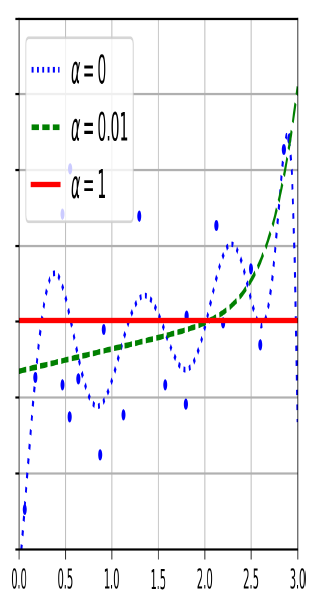
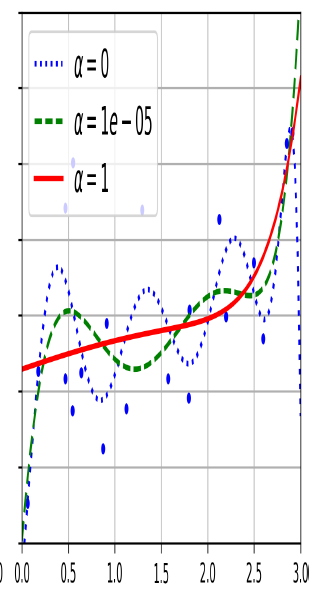

### In That part we found that Ridgge is better because it has less effect on smoothing

## Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
Dr=DecisionTreeRegressor(random_state=2002)
Dr.fit(X_train,y_train)
print(Dr.score(X_train,y_train))
print(Dr.score(X_test,y_test))

1.0
0.486262522539624


After we controlled Max Depth & Max Features.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
Dr=DecisionTreeRegressor(random_state=2002,max_depth=16,splitter="best",max_features=16)
Dr.fit(X_train,y_train)
print(Dr.score(X_train,y_train))
print(Dr.score(X_test,y_test))

0.997869159879887
0.8297301128811797


In [ ]:
from sklearn import tree
plt.figure(figsize=(40,40))
tree.plot_tree(Dr,feature_names = X_train.columns,class_names='Profit',fontsize=16,filled=True)
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-68-ca7376832981>", line 4, in <cell line: 4>
    plt.show()
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py", line 446, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/display.py", line 320, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "<decorator-gen-2>", line 2, in __call__
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/formatters.py", line 224, in catch_format_error
    r = method(se

TypeError: ignored

We Noticed That after control max depth and making tree pre-truning we managed to overcome overfitting 

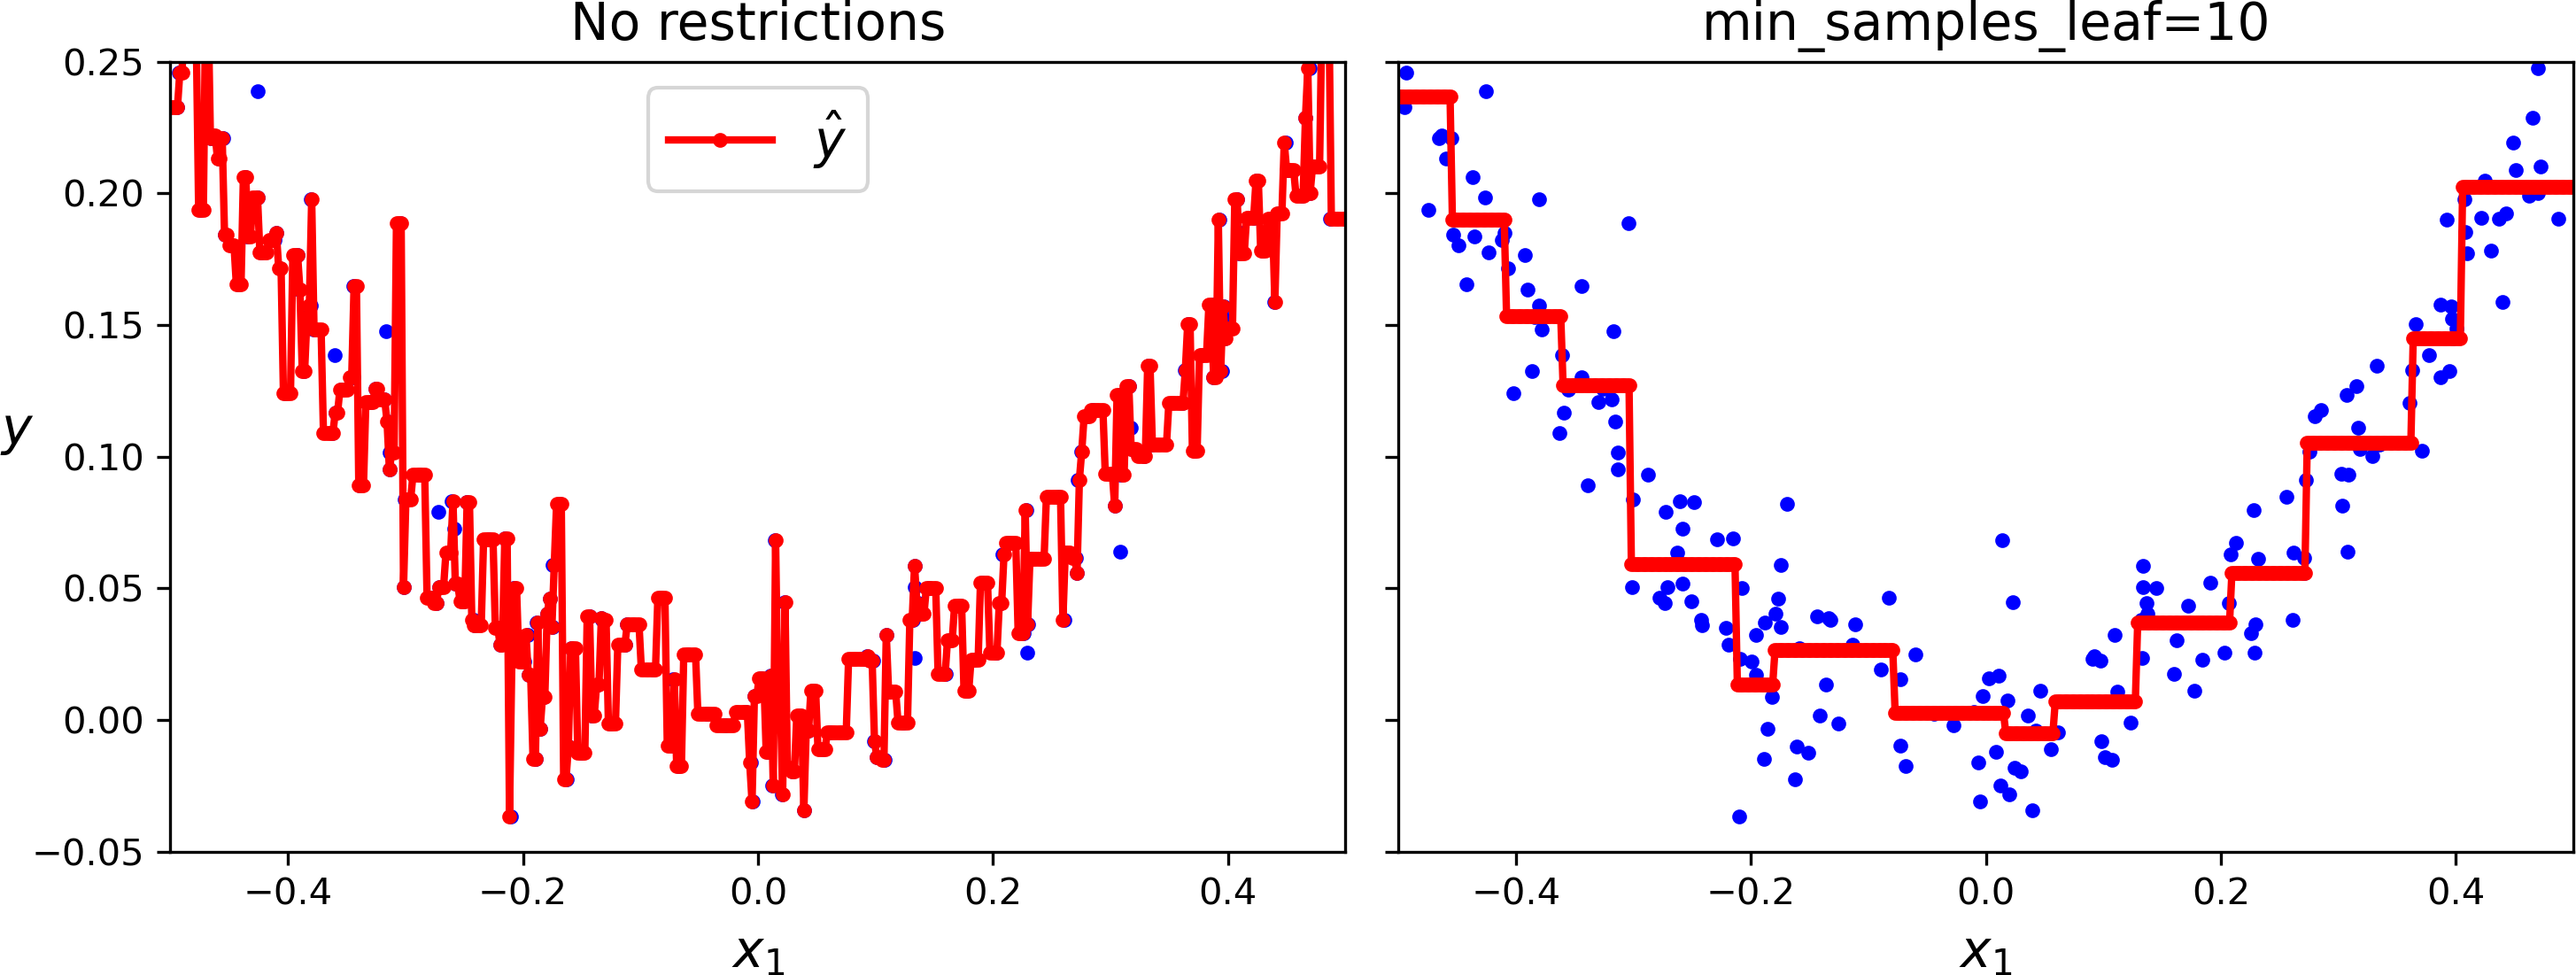



*   But Unfortunatly it overfits easily so we will try to use another method.



Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the
best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning
it does only slightly better than random guessing), the ensemble can still be a strong
learner (achieving high accuracy), provided there are a sufficient number of weak
learners and they are sufficiently diverse.
How is this possible? The following analogy can help shed some light on this mystery.
Suppose you have a slightly biased coin that has a 51% chance of coming up heads and
49% chance of coming up tails. If you toss it 1,000 times, you will generally get more
or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you
will find that the probability of obtaining a majority of heads after 1,000 tosses is close
to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses,
the probability climbs over 97%). This is due to the law of large numbers: as you keep
tossing the coin, the ratio of heads gets closer and closer to the probability of heads
(51%). Figure 7-3 shows 10 series of biased coin tosses. You can see that as the number
of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up
so close to 51% that they are consistently above 50%.

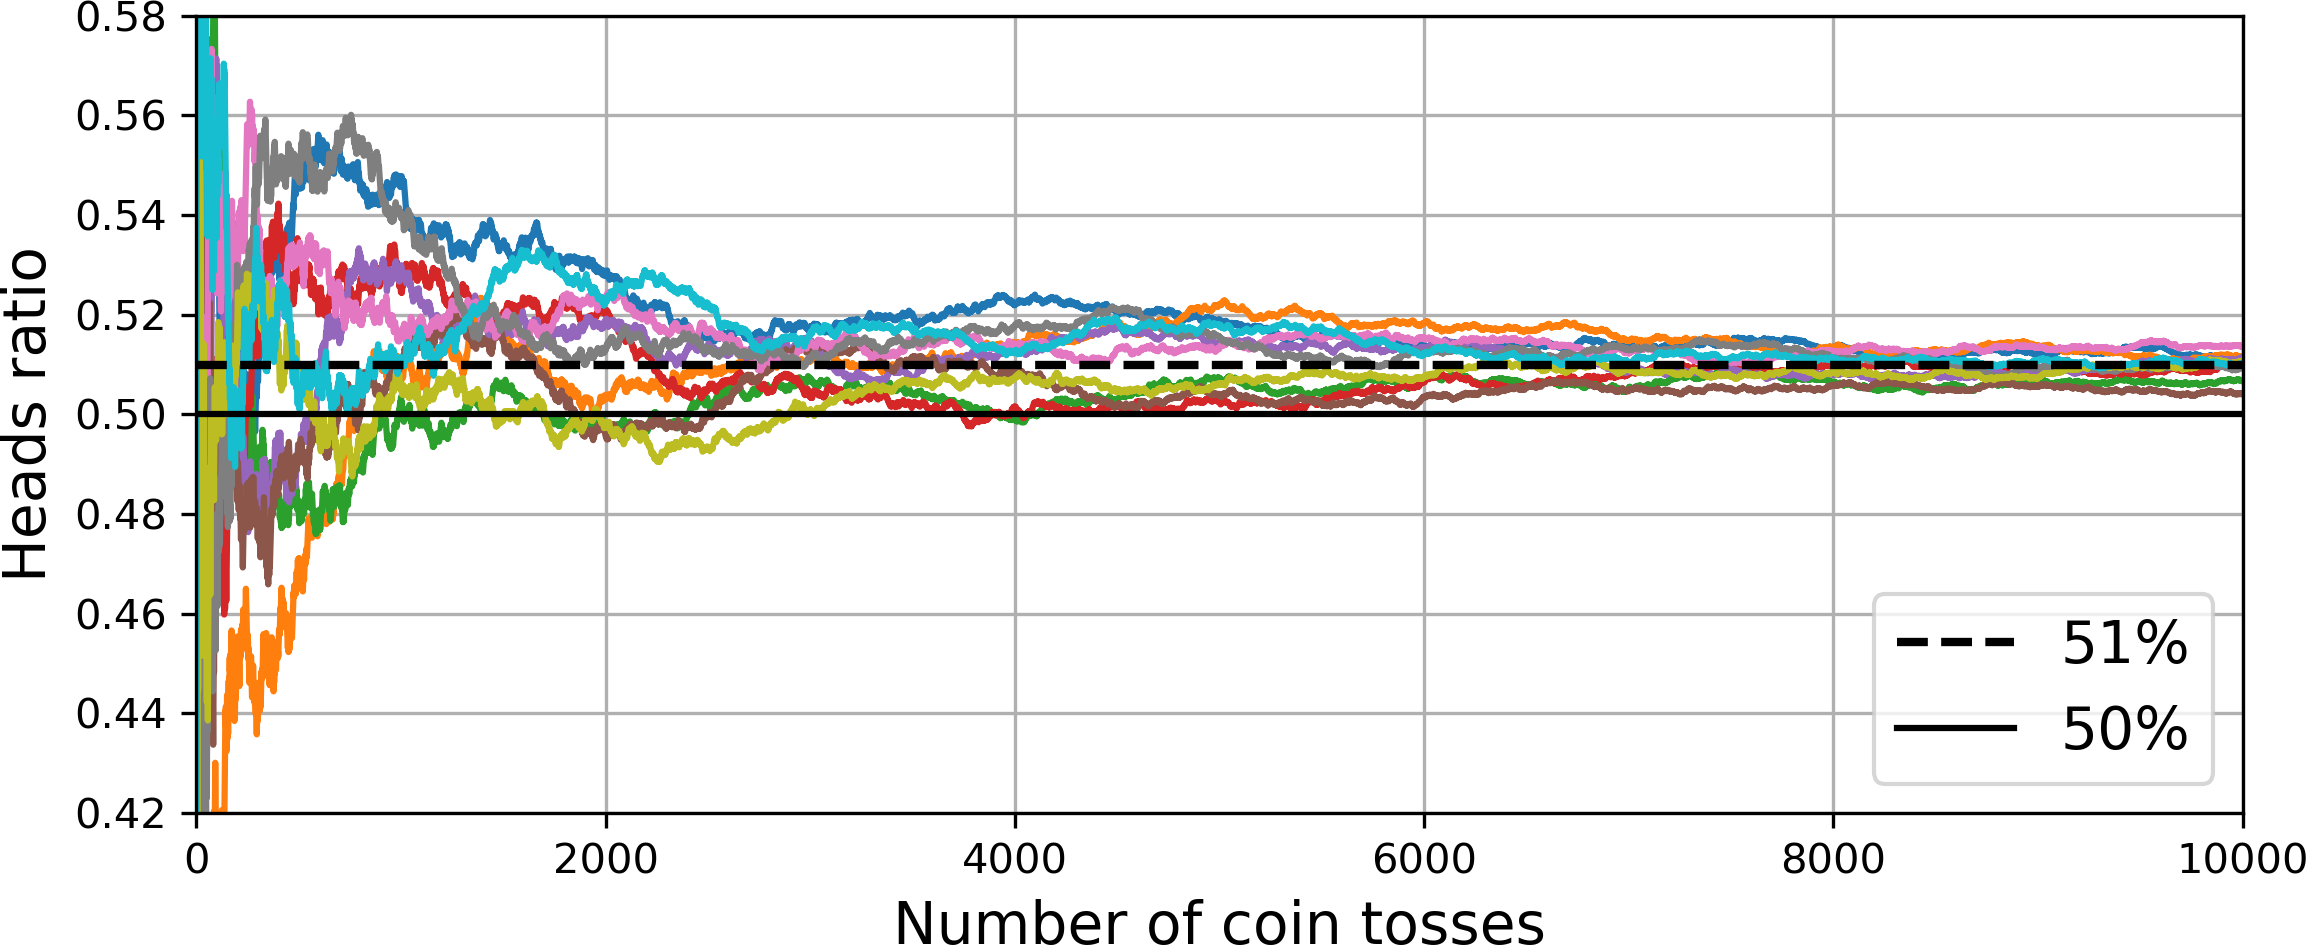

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
X_train.columns=X_train.columns.astype(str)
RFR = RandomForestRegressor(random_state=2002,n_estimators=500)
RFR.fit(X_train, y_train)


In [ ]:
X_test.columns=X_test.columns.astype(str)
print(RFR.score(X_train,y_train))
print(RFR.score(X_test,y_test))

In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(RFR.predict(X_train),y_train))
print(mean_squared_error(RFR.predict(X_test),y_test))

## XGBRegressor

In [ ]:
from xgboost import XGBRegressor
model_bosst = XGBRegressor(n_estimators=200,random_state=20)
model_bosst.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=20, ...)

In [ ]:
print(model_bosst.score(X_train,y_train))
print(model_bosst.score(X_test,y_test))


0.9996133762114032
0.8181945459630718


In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(model_bosst.predict(X_train),y_train))
print(mean_squared_error(model_bosst.predict(X_test),y_test))


19.16773672543772
6322.810313316641


In [ ]:
from xgboost import XGBRegressor
model_bosst = XGBRegressor(n_estimators=500,random_state=20,max_depth=3,max_leaves=6,learning_rate=0.5)
model_bosst.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=6,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=20, ...)

In [ ]:
print(model_bosst.score(X_train,y_train))
print(model_bosst.score(X_test,y_test))


0.9985211037650523
0.9001361765225616


In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(model_bosst.predict(X_train),y_train))
print(mean_squared_error(model_bosst.predict(X_test),y_test))


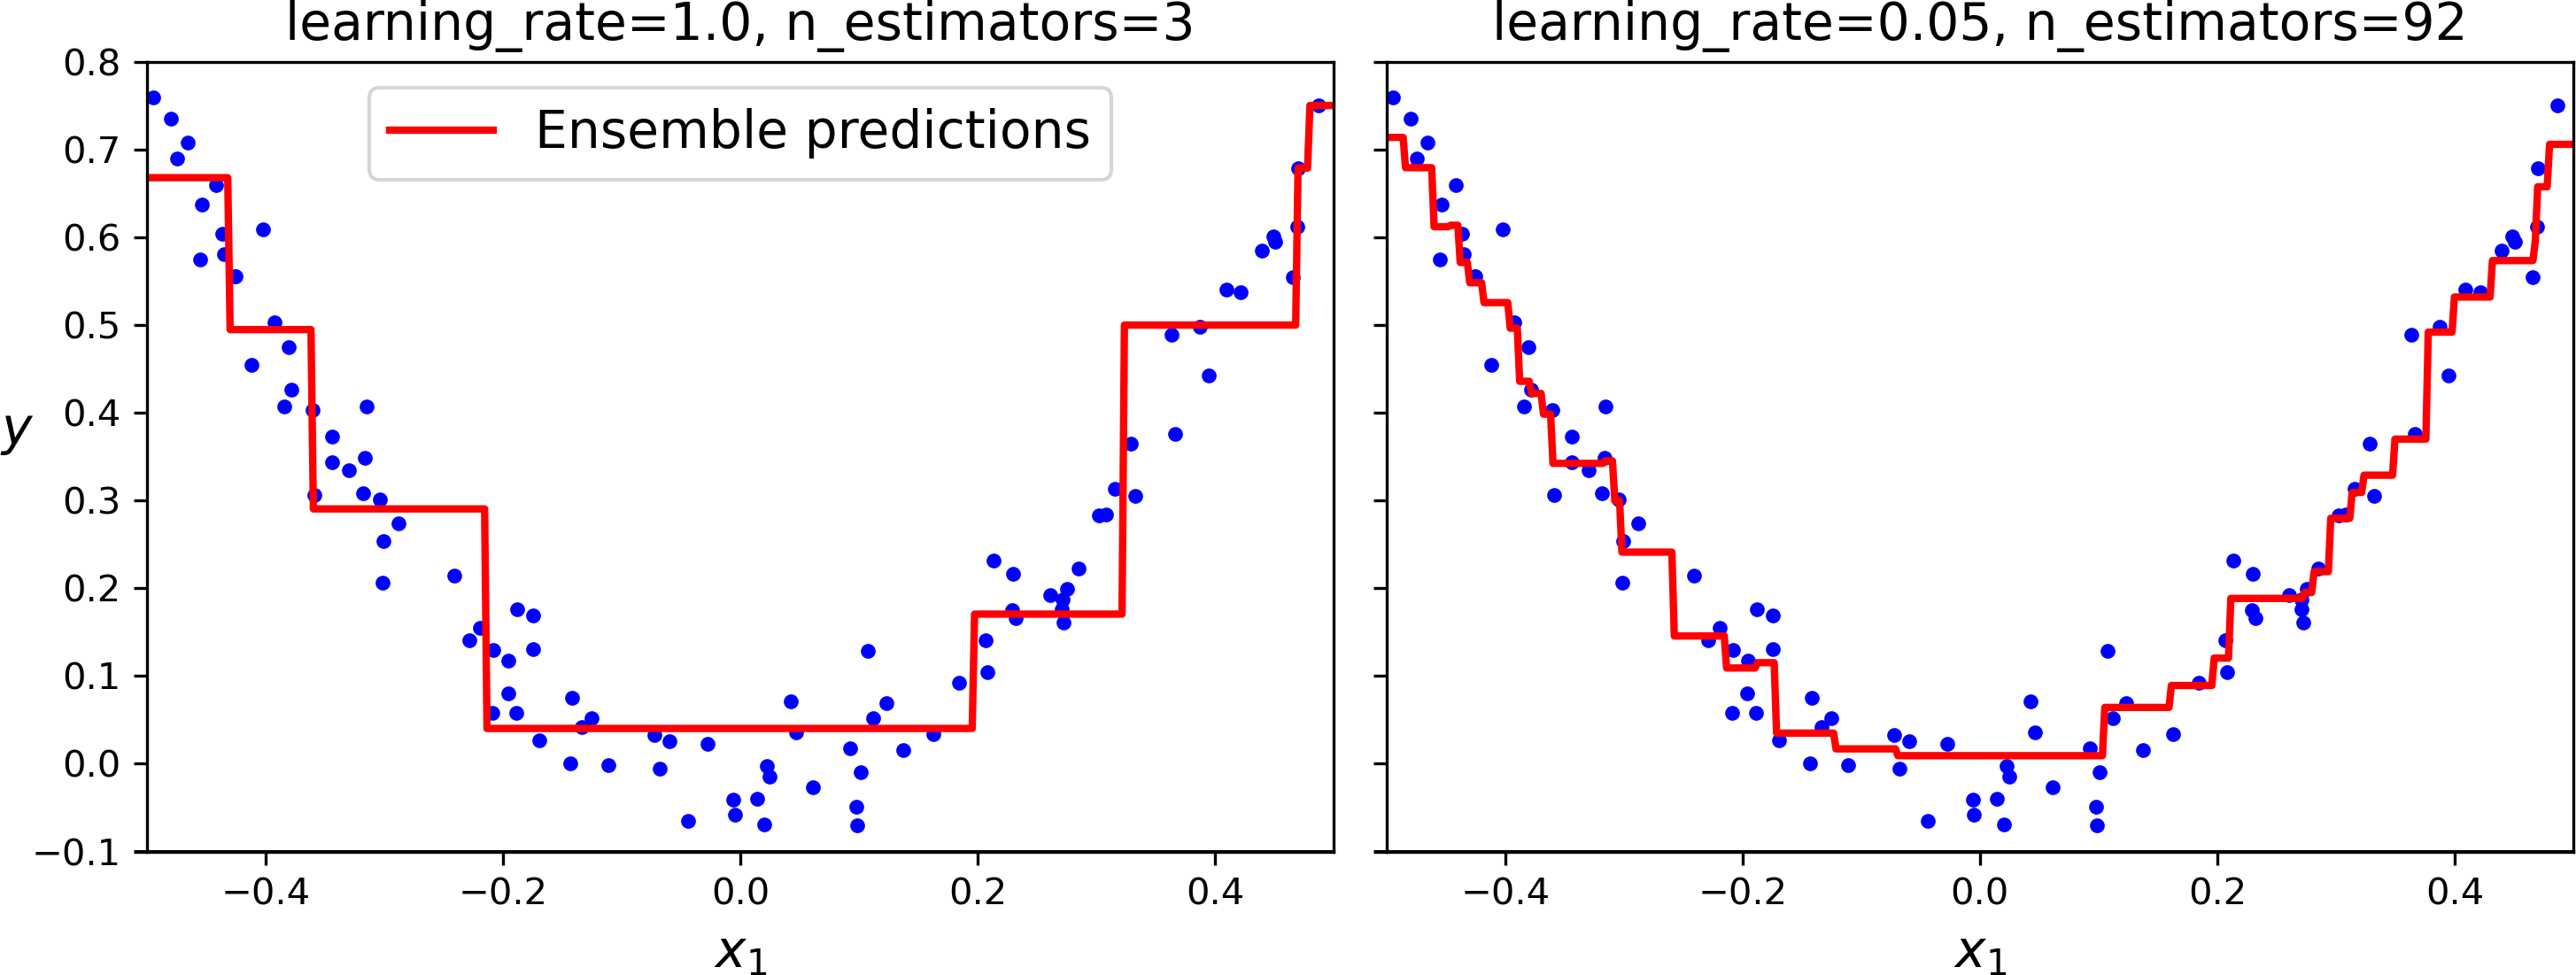

In [ ]:
from xgboost import plot_tree
plot_tree(model_bosst,num_trees=20)
plt.show()

## Neural Network

In [ ]:
reg = Sequential([ 
# Adding the input layer and the first hidden layer
Dense(units = 512, activation = 'relu'),
# Adding the second hidden layer
Dense(units = 320, activation = 'relu'),
Dense(units = 250, activation = 'relu'),
Dense(units = 128, activation = 'relu'),
Dropout(0.1),
BatchNormalization(),
Dense(units = 64, activation = 'relu'),
# Adding the output layer
Dense(units = 1, activation = 'relu'),

])

In [ ]:
reg.compile(optimizer = 'adam', loss=keras.losses.MeanSquaredError(), metrics = ['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(lr=0.5,monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00001)
reg.fit(X_train, y_train, batch_size = 5996, epochs = 170,callbacks=[learning_rate_reduction])

In [ ]:
y_pr = reg.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pr)

# Serialization

In [ ]:
import pickle
pickle_out = open("Saved Object/Myscale.pickle","wb")
pickle.dump(scale, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("Saved Object/Myscale.pickle","rb")
example_dict = pickle.load(pickle_in)


In [ ]:
pickle_out = open("Saved Object/Dreg.pickle","wb")
pickle.dump(Dr, pickle_out)
pickle_out.close()

In [ ]:

pickle_out = open("Saved Object/XGBReg.pickle","wb")
pickle.dump(model_bosst, pickle_out)
pickle_out.close()

In [ ]:
model_bosst.save_model("Saved Object/XGBReg.txt")

In [99]:
pickle_out = open("Saved Object/ridge.pickle","wb")
pickle.dump(ridge, pickle_out)
pickle_out.close()

In [100]:
pickle_out = open("Saved Object/ptrans.pickle","wb")
pickle.dump(ptrans, pickle_out)
pickle_out.close()

In [ ]:
import pickle
pickle.load(open("Saved Object/ridge.pickle","rb"))

Ridge(alpha=0.1)